# QL pipeline

## short cadence

https://exofop.ipac.caltech.edu/tess/target.php?id=

In [1]:
tic = 

## long cadence

In [2]:
import chronos as cr

l = cr.LongCadence(ticid=tic, sap_mask='square', aper_radius=1)
d = l.query_gaia_dr2_catalog(return_nearest_xmatch=True)
l.get_all_sectors()

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Available sectors: [7]
Using sector=7.
Querying Gaia DR2 catalog for 106.211 -8.56657 within 3.0 arcsec.



[7]

Searching targetpixelfile using Tesscut
Applying data quality mask identified in Data Release Notes (sector 7):
aperture photometry mask: square (1x1 pix)

Brightest star detected is near the edges.
Aperture mask is placed at the center instead.



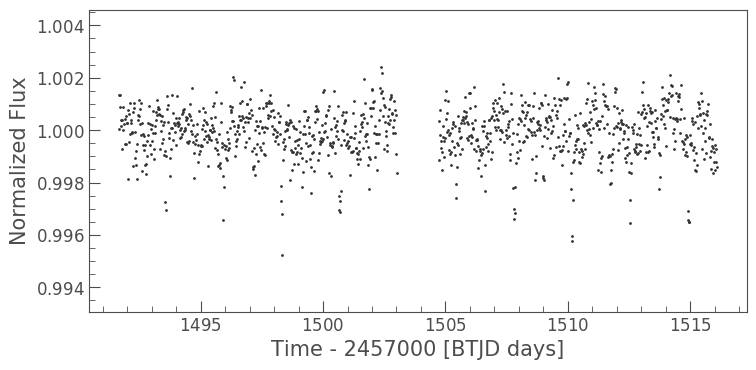

In [3]:
lc = l.make_custom_lc(sap_mask=l.sap_mask, aper_radius=l.aper_radius,
                      #sap_mask='threshold', threshold_sigma=5
                     )
lc.scatter()

Querying Gaia DR2 catalog for 106.211 -8.56657 within 60.0 arcsec.

Brightest star detected is near the edges.
Aperture mask is placed at the center instead.



(20, 30)

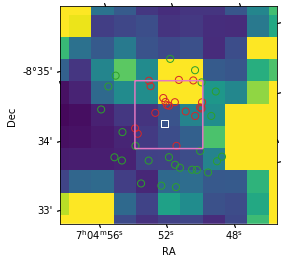

In [4]:
tpf = l.tpf_tesscut
gaia_sources = l.query_gaia_dr2_catalog(radius=60)
ax = cr.plot_gaia_sources_on_tpf(tpf, target_gaiaid=l.gaiaid, 
                                 gaia_sources=gaia_sources, 
                                 sap_mask=l.sap_mask, aper_radius=l.aper_radius
                                )

s = l.cutout_size[0]//2
r = 5
ax.set_xlim(s-r,s+r)
ax.set_ylim(s-r,s+r)

Brightest star detected is near the edges.
Aperture mask is placed at the center instead.

Querying DSS2 Red (120.00 arcsec x 120.00 arcsec) archival image


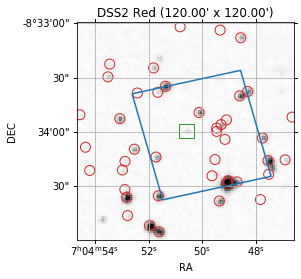

In [5]:
import astropy.units as u

ax = cr.plot_gaia_sources_on_survey(tpf, target_gaiaid=l.gaiaid, 
                                 gaia_sources=gaia_sources, 
                                 sap_mask=l.sap_mask, aper_radius=l.aper_radius,
                                 fov_rad=120*u.arcsec)

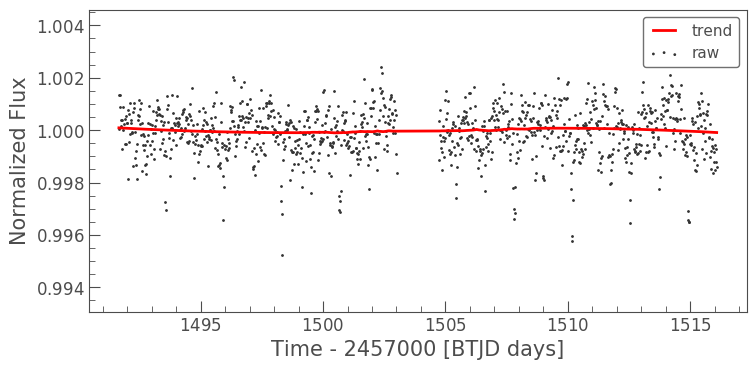

In [6]:
flat, trend = lc.flatten(window_length=701, break_tolerance=301, return_trend=True)
ax = lc.scatter(label='raw')
trend.plot(label='trend', lw=2, c='r', ax=ax)

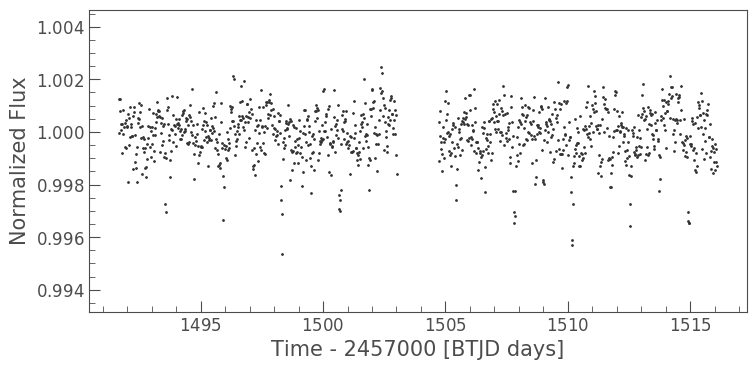

In [7]:
flat.scatter()

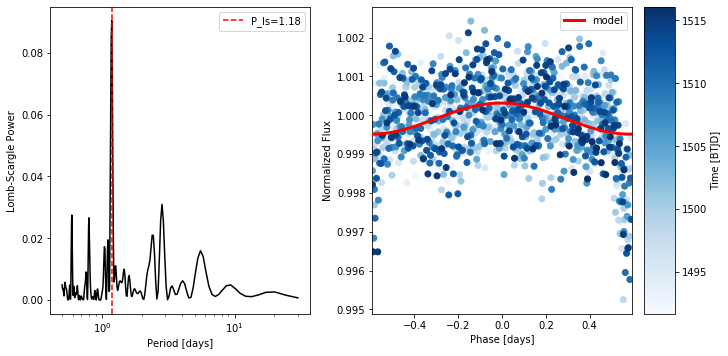

In [8]:
fig = cr.plot_lomb_scargle(lc.time, lc.flux);

  0%|          | 0/2182 periods | 00:00<?

Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 27 durations
Searching 1086 data points, 2182 periods from 0.601 to 12.208 days
Using all 8 CPU threads


100%|██████████| 2182/2182 periods | 00:04<00:00 


(0.3, 0.7)

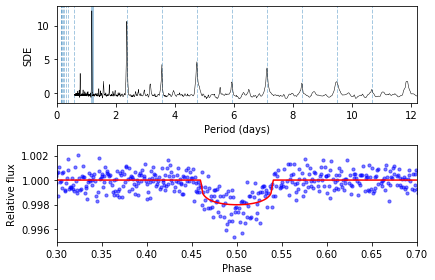

In [9]:
import transitleastsquares as tls

tls_results = tls.transitleastsquares(flat.time, flat.flux).power()
fig = cr.plot_tls(tls_results);
fig.axes[1].set_xlim(0.3,0.7)

(-0.3, 0.3)

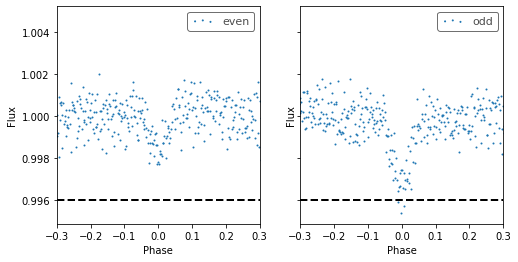

In [13]:
import matplotlib.pyplot as pl

xlims = (-0.3,0.3)
y =0.996

fig, axs = pl.subplots(1,2, figsize=(8,4), sharey=True)
fold = flat.fold(period=tls_results.period, t0=tls_results.T0)

ax = axs[0]
fold[fold.even_mask].scatter(label='even', ax=ax)
ax.axhline(y, 0, 1, lw=2, ls='--', c='k')
ax.set_xlim(*xlims)

ax = axs[1]
fold[fold.odd_mask].scatter(label='odd', ax=ax)
ax.axhline(y, 0, 1, lw=2, ls='--', c='k')
ax.set_xlim(*xlims)

In [11]:
import astropy.units as u

tic_params = l.query_tic_catalog(return_nearest_xmatch=True)
Rp = tls_results['rp_rs']*l.tic_params['rad']*u.Rsun.to(u.Rearth)
Rp

Querying TIC catalog for 106.211 -8.56657
            within 3.0 arcsec.



3.263596965549694

Brightest star detected is near the edges.
Aperture mask is placed at the center instead.

Querying DSS2 Red (120.00 arcsec x 120.00 arcsec) archival image


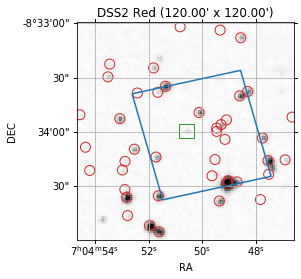

In [12]:
import astropy.units as u

ax = cr.plot_gaia_sources_on_survey(tpf, target_gaiaid=l.gaiaid, 
                                 gaia_sources=gaia_sources, 
                                 sap_mask=l.sap_mask, aper_radius=l.aper_radius,
                                 fov_rad=120*u.arcsec,
                                   depth=1-tls_results.depth
                                   )

additional periodic signals

  0%|          | 0/2173 periods | 00:00<?

Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 27 durations
Searching 919 data points, 2173 periods from 0.601 to 12.167 days
Using all 8 CPU threads


100%|██████████| 2173/2173 periods | 00:03<00:00


(0.4, 0.6)

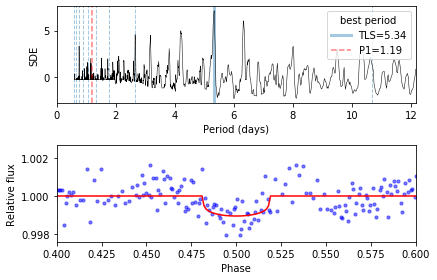

In [14]:
#mask transit
intransit = tls.transit_mask(lc.time, tls_results.period, 2*tls_results.duration, tls_results.T0)
time2 = lc.time[~intransit]
flux2 = lc.flux[~intransit]

#re-run tls
tls_results2 = tls.transitleastsquares(time2, flux2).power()

fig = cr.plot_tls(tls_results2);
#add period from toi release for reference 
fig.axes[0].axvline(tls_results.period, 0, 1, c='r', ls='--', alpha=0.5, label=f'P1={tls_results.period:.2f}')
fig.axes[0].legend(title='best period')
# fig.axes[1].set_ylim(0.998,1.002)
fig.axes[1].set_xlim(0.4,0.6)